# 감정 분석(Sentiment Analysis)

* 감정 분석은 텍스트에 등장하는 단어들을 통해 어떤 감정이 드러나는지 분석하는 기법
* 감정 분석은 오피니언 마이닝으로도 불리며, 텍스트에 담긴 의견, 태도 등을 알아보는데 유용한 기법
* 감정 분석을 하기 위해선 미리 정의된 감정 어휘 사전이 필요
* 감정 어휘 사전에 포함된 어휘가 텍스트에 얼마나 분포하는지에 따라 해당 텍스트의 감정이 좌우
* 토픽 모델링이 텍스트의 주제를 찾아낸다면, 감정 분석은 텍스트의 의견을 찾아냄
* 텍스트는 주제(토픽)와 의견(감정)의 결합으로 이루어졌다고 볼 수 있음

![2655364B5925AC9606[1].png](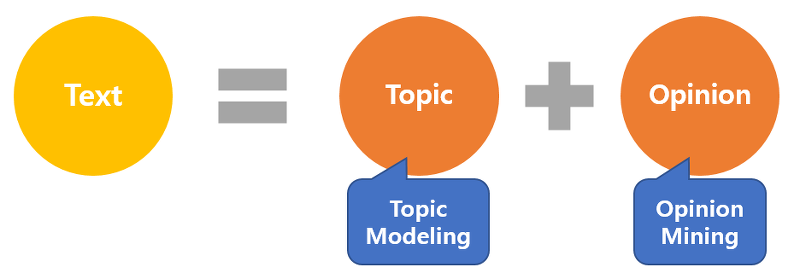)

* 감정 분석은 SNS, 리뷰 분석에 유용하게 사용할 수 있음
* 특정 이슈에 대한 사람들의 감정을 실시간으로 분석한다면, 그에 대해 신속하게 대처 가능

* 파이썬으로 감정 분석하는 방법은 크게 두 가지로 구분
  + `감정 어휘 사전`을 이용한 감정 상태 분류
    -  미리 분류해둔 감정어 사전을 통해 분석하고자 하는 텍스트의 단어들을 사전에 기반해 분류하고, 그 감정가를 계산
    - 이 때 사용되는 감정어 사전에는 해당 감정에 해당되는 단어를 미리 정의해둬야 함
  + `기계학습`을 이용한 감정 상태 분류
    - 분석 데이터의 일부를 훈련 데이터로 사용해 그로부터 텍스트의 감정 상태를 분류
    - 이 때 사용되는 훈련 데이터는 사용자가 분류한 감정 라벨이 포함되어 있어야 하며,  
이를 인공 신경망, 의사 결정 트리 등의 기계 학습 알고리즘을 사용하여 분류

## 1.감정 어휘 사전을 이용한 감정 상태 분류

### 감정 사전 준비

*   `감정 사전 라이브러리`를 설치
*   `afinn`은 영어에 대한 긍정, 부정에 대한 감정 사전을 제공


### 데이터 준비

1.   사용할 데이터를 구성 
2.   데이터는 사이킷런에 내장되어 있는 `뉴스그룹 데이터`를 이용

In [1]:
from sklearn.datasets import fetch_20newsgroups

newsdata = fetch_20newsgroups(subset='train')
newsdata.data[0]

C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

### 감정 상태 분류 및 시각화

*   감정 사전을 구성하고 감정 스코어를 측정
*   afinn 라이브러리는 감정 사전과 더불어 편리하게 감정가를 계산할 수 있는 함수를 제공

In [2]:
from afinn import Afinn

afinn = Afinn()
for i in range(10) :
    print(afinn.score(newsdata.data[i]))

7.0
11.0
16.0
5.0
-23.0
-25.0
7.0
3.0
16.0
-20.0


*   모든 뉴스에 대한 감정을 시각화
*   긍정과 부정에 대한 갯수를 시각화



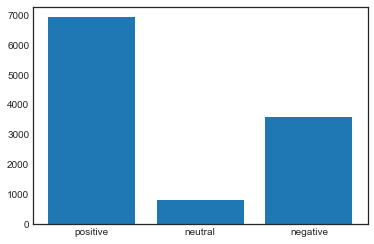

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

positive=0
neutral = 0
negative=0

for i in newsdata.data:
    score = afinn.score(i)
    if score > 0 :
        positive += 1
    elif score == 0:
        neutral += 1
    else :
        negative += 1
        
#전체 긍정/부정/neutral 개수가 나옴
plt.bar(np.arange(3), [positive, neutral, negative])
plt.xticks(np.arange(3), ['positive', 'neutral', 'negative'])
plt.show()

## 2.기계학습을 이용한 감정 분석

#### 한국어 자연어 처리 konlpy와 형태소 분석기 MeCab 설치

* https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

In [53]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 네이버 영화 리뷰 데이터

* 참고: https://wikidocs.net/44249

#### 데이터 로드

* 데이터를 웹에서 바로 받아오기 위해 `urllib.request` 사용
  + https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
  + https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
* 받아온 데이터를 `dataframe`으로 변환하고 데이터를 확인



In [54]:
train_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
test_file = urllib.request.urlopen("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt")

In [55]:
train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data[:10]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


#### 중복 및 결측치 처리

*   데이터 개수 확인
*   데이터에 중복이 존재한다면 이를 제거



In [56]:
print(train_data['document'].nunique())
print(train_data['label'].nunique())

146182
2


In [57]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [58]:
print(train_data.isnull().sum())
train_data = train_data.dropna(how='any')

id          0
document    1
label       0
dtype: int64


#### 데이터 정제



*   데이터에서 한글과 공백을 제외하고 모두 제거



In [59]:
train_data['document']=train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [60]:
train_data[:10]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


In [61]:
#정규표현식으로 제거하고 난후 빈 데이터가 391이 되었음
train_data['document'].replace('', np.nan, inplace=True)
print(len(train_data))
print(train_data.isnull().sum())

146182
id            0
document    391
label         0
dtype: int64


In [62]:
train_data = train_data.dropna(how='any')
print(len(train_data))

145791


In [63]:
#테스트 데이터도 똑같이 전처리
test_data.drop_duplicates(subset=['document'], inplace = True)
test_data['document']=test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print(len(test_data))

48995


C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


#### 토큰화 및 불용어 제거



* 단어들을 분리하고 불용어를 제거함
* 불용어 사전: `'의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'`



In [64]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [65]:
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

X_train = []
for sentence in train_data['document'] :
    X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [66]:
X_train[:2]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나']]

In [67]:
X_test = []
for sentence in test_data['document'] :
    X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [68]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
#print(tokenizer.word_index)

#### 빈도 수가 낮은 단어 제거



*   빈도 수가 낮은 단어는 학습에 별로 영향을 주지 않음
*   처리를 통해 빈도 수가 낮은 단어들은 제거



In [69]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items() : #word_counts값을 dictionary로 받아옴
    words_freq = words_freq + value
    
    if value < threshold : #rare한거 개수셈
        rare_cnt += 1
        rare_freq = rare_freq + value
        
print("전체 단어 수: " , words_cnt)
print("빈도가 {} 이하인 희귀 단어 수 : {}".format(threshold-1, rare_cnt))
print("희귀 단어 비율 : {}".format(rare_cnt / words_cnt))
print("희귀 단어 등장 빈도 비율 : {}".format((rare_freq/words_freq)*100 ))

전체 단어 수:  49946
빈도가 2 이하인 희귀 단어 수 : 28320
희귀 단어 비율 : 0.5670123733632323
희귀 단어 등장 빈도 비율 : 1.7606788534131563


In [70]:
vocab_size = words_cnt - rare_cnt + 2 #2는 0번째 패딩, out of vocabulary token 넣어줘야해서 
print(vocab_size)

21628


In [71]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train) #seqeunce 형태로 변형
X_test = tokenizer.texts_to_sequences(X_test) 

In [72]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [73]:
drop_train = [index for index,sentece in enumerate(X_train) if len(sentence) < 1] 
X_train = np.delete(X_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_train, axis=0)

print(len(X_train))
print(len(X_test))

145791
48995


C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 패딩



*   리뷰의 전반적인 길이를 확인
*   모델의 입력을 위해 동일한 길이로 맞춰줌



In [74]:
print("리뷰 최대 길이 :" , max(len(l) for l in X_train))
print('리뷰 평균 길이 :' , sum(map(len, X_train))/len(X_train))

리뷰 최대 길이 : 83
리뷰 평균 길이 : 13.762454472498302


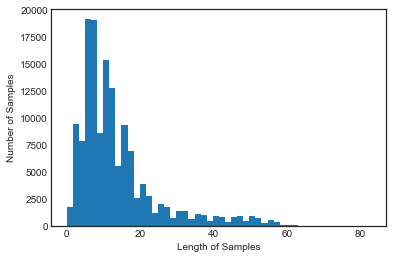

In [75]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [76]:
max_len = 60

In [77]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#### 모델 구축 및 학습

*   감정 상태 분류 모델을 선언하고 학습
*   모델은 일반적인 `LSTM 모델`을 사용



In [78]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

In [79]:
model = Sequential()
model.add(Embedding(vocab_size, 100)) #dimension
model.add(LSTM(128))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2162800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,280,177
Trainable params: 2,280,177
Non-trainable params: 0
_________________________________________________________________


In [81]:
history = model.fit(X_train, y_train, epochs=3, batch_size=60, validation_split=0.2)

Epoch 1/3
1944/1944 [==============================] - 247s 127ms/step - loss: 0.3794 - acc: 0.8303 - val_loss: 0.3507 - val_acc: 0.8472
Epoch 2/3
1944/1944 [==============================] - 237s 122ms/step - loss: 0.3198 - acc: 0.8623 - val_loss: 0.3236 - val_acc: 0.8604
Epoch 3/3
1944/1944 [==============================] - 265s 136ms/step - loss: 0.2915 - acc: 0.8767 - val_loss: 0.3155 - val_acc: 0.8651


In [82]:
model.evaluate(X_test, y_test)

1532/1532 [==============================] - 38s 25ms/step - loss: 0.3186 - acc: 0.8612


[0.31855258345603943, 0.8611899018287659]

### 시각화

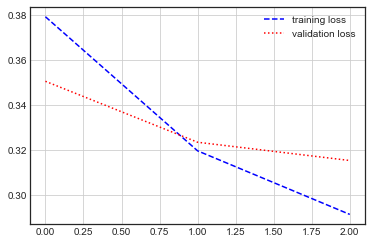

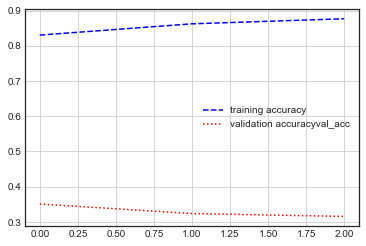

In [83]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label = 'training loss')
plt.plot(val_loss, 'r:', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label = 'training accuracy')
plt.plot(val_loss, 'r:', label = 'validation accuracyval_acc')
plt.legend()
plt.grid()

plt.show()

### 감정예측

In [84]:
def sentiment_predict(new_sentence) :
    new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen=max_len)
    score = float(model.predict(new_pad))
    
    if score > 0.5 :
        print("{} -> 긍정({:.2f}%)".format(new_sentence, score*100))
    else :
        print("{} -> 부정({:.2f}%)".format(new_sentence, (1-score)*100))

In [87]:
sentiment_predict('정말 재미있고 흥미진진 했어요')
sentiment_predict('그냥 그래요 ..')
sentiment_predict('제 스타일인지 아닌지')

정말 재미있고 흥미진진 했어요 -> 긍정(99.20%)
그냥 그래요 .. -> 부정(92.16%)
제 스타일인지 아닌지 -> 부정(54.66%)


## 네이버 쇼핑 리뷰 데이터

* 참고: https://wikidocs.net/94600
* 다운로드 링크 : https://github.com/bab2min/corpus/tree/master/sentiment

### 데이터 로드

In [123]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x28a9136b088>)

In [124]:
total_data = pd.read_table('shopping.txt')
print(len(total_data))

50000


In [125]:
total_data[:10]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1
6,6315043,진정한 쓰레기,0
7,6097171,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
8,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,6242223,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1


### 훈련 데이터와 테스트 데이터 분류

In [126]:
#total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
#total_data[:5]

In [127]:
total_data['document'].nunique(), total_data['label'].nunique()

(49157, 2)

In [128]:
total_data.drop_duplicates(subset=['document'], inplace=True)
print(len(total_data))

49158


In [129]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=111)
print(len(train_data))
print(len(test_data))

36868
12290


### 레이블의 분포 확인

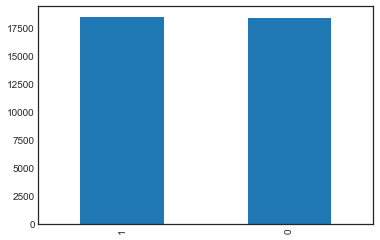

In [130]:
train_data['label'].value_counts().plot(kind='bar')

In [131]:
train_data.groupby('label').size().reset_index(name='count')

,label,count
0,0,18392
1,1,18476


### 데이터 정제

In [133]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
print(len(test_data))

id            0
document    117
label         0
dtype: int64
12290


C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
C:\Users\bini\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\bini\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:6610: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [134]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
print(len(test_data))

id            0
document    117
label         0
dtype: int64
12290


C:\Users\bini\anaconda3\envs\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


### 토큰화 및 불용어 제거

In [135]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [151]:
train_data['document'] = train_data['document'].apply(lambda _: str(_))
test_data['document'] = test_data['document'].apply(lambda _: str(_))

In [157]:
X_train = train_data['document'].apply(mecab.morphs)
X_train = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [158]:
X_test = test_data['document'].apply(mecab.morphs)
X_test = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

#### 빈도 수가 낮은 단어 제거



*   빈도 수가 낮은 단어는 학습에 별로 영향을 주지 않음
*   처리를 통해 빈도 수가 낮은 단어들은 제거



In [159]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [160]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items() : #word_counts값을 dictionary로 받아옴
    words_freq = words_freq + value
    
    if value < threshold : #rare한거 개수셈
        rare_cnt += 1
        rare_freq = rare_freq + value
        
print("전체 단어 수: " , words_cnt)
print("빈도가 {} 이하인 희귀 단어 수 : {}".format(threshold-1, rare_cnt))
print("희귀 단어 비율 : {}".format(rare_cnt / words_cnt))
print("희귀 단어 등장 빈도 비율 : {}".format((rare_freq/words_freq)*100 ))

전체 단어 수:  26258
빈도가 2 이하인 희귀 단어 수 : 16401
희귀 단어 비율 : 0.6246096427755351
희귀 단어 등장 빈도 비율 : 4.5010984519491135


In [161]:
vocab_size = words_cnt - rare_cnt + 2 #2는 0번째 패딩, out of vocabulary token 넣어줘야해서 
print(vocab_size)

9859


In [162]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train) #seqeunce 형태로 변형
X_test = tokenizer.texts_to_sequences(X_test) 

### 패딩

리뷰 최대 길이 : 70
리뷰 평균 길이 : 12.210562004990777


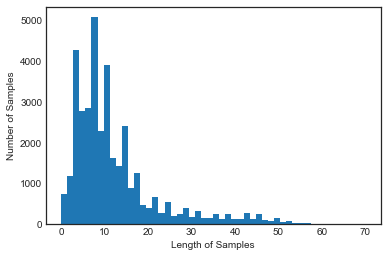

In [163]:

print("리뷰 최대 길이 :" , max(len(l) for l in X_train))
print('리뷰 평균 길이 :' , sum(map(len, X_train))/len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [164]:
max_len = 40
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### 모델 구축

In [166]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [168]:
model = Sequential()
model.add(Embedding(vocab_size, 100)) #dimension
model.add(GRU(128))
model.add(Dense(1,activation = 'sigmoid'))



In [167]:
es = EarlyStopping(monitor = 'val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [169]:
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         985900    
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,074,349
Trainable params: 1,074,349
Non-trainable params: 0
_________________________________________________________________


In [175]:
y_train = train_data['label']
y_test = test_data['label']

In [176]:
history = model.fit(X_train, y_train, epochs =3, callbacks=[es,mc], batch_size=60, validation_split=0.2)

Epoch 1/3
492/492 [==============================] - 21s 42ms/step - loss: 0.4767 - acc: 0.7582 - val_loss: 0.3881 - val_acc: 0.8226

Epoch 00001: val_acc improved from 0.51126 to 0.82262, saving model to best_model.h5
Epoch 2/3
492/492 [==============================] - 30s 61ms/step - loss: 0.3502 - acc: 0.8469 - val_loss: 0.3766 - val_acc: 0.8270

Epoch 00002: val_acc improved from 0.82262 to 0.82696, saving model to best_model.h5
Epoch 3/3
492/492 [==============================] - 35s 71ms/step - loss: 0.3099 - acc: 0.8700 - val_loss: 0.3685 - val_acc: 0.8381

Epoch 00003: val_acc improved from 0.82696 to 0.83808, saving model to best_model.h5


In [177]:
loaded_model = load_model('best_model.h5')
loaded_model.evaluate(X_test, y_test)

385/385 [==============================] - 4s 10ms/step - loss: 0.7001 - acc: 0.5074


[0.7000710368156433, 0.5074043869972229]

### 시각화

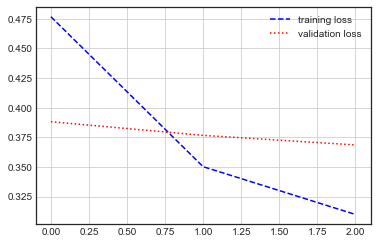

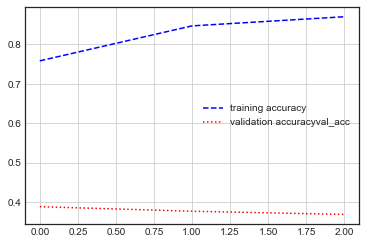

In [178]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label = 'training loss')
plt.plot(val_loss, 'r:', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label = 'training accuracy')
plt.plot(val_loss, 'r:', label = 'validation accuracyval_acc')
plt.legend()
plt.grid()

plt.show()

### 감정 예측

In [180]:
def sentiment_predict(new_sentence) :
    new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen=max_len)
    score = float(loaded_model.predict(new_pad))
    
    if score > 0.5 :
        print("{} -> 긍정({:.2f}%)".format(new_sentence, score*100))
    else :
        print("{} -> 부정({:.2f}%)".format(new_sentence, (1-score)*100))

In [182]:
sentiment_predict('처음 써봤는데 맘에 들어요')
sentiment_predict('휴가철에 딱이에요')
sentiment_predict('배송이 왜 이러나요')

처음 써봤는데 맘에 들어요 -> 긍정(93.55%)
휴가철에 딱이에요 -> 긍정(69.15%)
배송이 왜 이러나요 -> 부정(76.21%)
